<a href="https://colab.research.google.com/github/ignaciomz/CH_IM_61195/blob/main/NLP_ReviewsPeliculasEspa%C3%B1ol_IgnacioMartinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Descargar el archivo desde GitHub
!wget https://raw.githubusercontent.com/ignaciomz/CH_IM_61195/refs/heads/main/reviews_filmaffinity.csv -O reviews_filmaffinity.csv




--2024-12-16 00:15:19--  https://raw.githubusercontent.com/ignaciomz/CH_IM_61195/refs/heads/main/reviews_filmaffinity.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11536979 (11M) [text/plain]
Saving to: ‘reviews_filmaffinity.csv’

reviews_filmaffinit 100%[===================>]  11.00M  --.-KB/s    in 0.08s   

2024-12-16 00:15:19 (140 MB/s) - ‘reviews_filmaffinity.csv’ saved [11536979/11536979]



In [2]:
# Ver las primeras líneas del archivo como texto
!head reviews_filmaffinity.csv


film_name||gender||film_avg_rate||review_rate||review_title||review_text
Ocho apellidos vascos||Comedia||6,0||3||OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO||La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho de nuestra madurez como nación (pese a quien pese). Bueno, corrijo: el hecho de que podamos jugar y hacer mofa y befa de los tópicos sobre los vascos y el nacionalismo vasco, sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho del grado de normalización de ciertas cuestiones que antes eran llagas abiertas siempre dispuestas a sangrar. Y hago esta corrección, porque los andaluces han sido motivo de guasa siempre y nunca ha pasado nada.Por esto mismo, el planteamiento de "Ocho Apellidos Vascos" es valiente, es oportuno y es oportunista. Seguramente sea esa una de las principales 

In [3]:
import pandas as pd

# Leer el archivo CSV con delimitador `||` y especificar las comillas
df = pd.read_csv(
    "reviews_filmaffinity.csv",  # Nombre del archivo
    sep=r"\|\|",  # Delimitador como expresión regular
    engine="python",  # Motor Python para soportar expresiones regulares
    quotechar='"',  # Caracter que envuelve texto, si aplica
    skip_blank_lines=True,  # Ignorar líneas en blanco
    on_bad_lines="skip"  # Saltar filas problemáticas
)

# Mostrar las primeras filas del DataFrame
df.head(20)



,film_name,gender,film_avg_rate,review_rate,review_title,review_text
0,Ocho apellidos vascos,Comedia,"6,0",3.0,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existen...
1,Ocho apellidos vascos,Comedia,"6,0",2.0,El perro verde,"No soy un experto cinéfilo, pero pocas veces m..."
2,Ocho apellidos vascos,Comedia,"6,0",2.0,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...
3,Ocho apellidos vascos,Comedia,"6,0",2.0,Aida: The movie,"No sé qué está pasando, si la gente se deja ll..."
4,Ocho apellidos vascos,Comedia,"6,0",2.0,UN HOMBRE SOLO (Julio Iglesias 1987),"""Pero cuando amanece,y me quedo solo,siento en..."
5,Ocho apellidos vascos,Comedia,"6,0",8.0,"Pues si para ti es una mierda, ¿para qué te la...",La llegada de Rafa a Euskadi es como ponerse a...
6,Ocho apellidos vascos,Comedia,"6,0",3.0,"¿LA MÁS TAQUILLERA? ASÍ NOS VA, ESTO ES LO QU...",El nivel del cine y lo peor la capacidad intel...
7,Ocho apellidos vascos,Comedia,"6,0",3.0,España como imposibilidad,Es triste ver una película como ésta y escucha...
8,Ocho apellidos vascos,Comedia,"6,0",1.0,"¿Que le pasa al público español? ¡ah si, Telec...",Puedo entender que Torrente I y II y Lo imposi...
9,Ocho apellidos vascos,Comedia,"6,0",1.0,"AHIVALAOSTIA, PISHA","-Ahivalohostia, Txomin, qué montón de gente ri..."


In [4]:
# Mostrar información sobre el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   film_name      8603 non-null   object 
 1   gender         8603 non-null   object 
 2   film_avg_rate  8603 non-null   object 
 3   review_rate    8601 non-null   float64
 4   review_title   8603 non-null   object 
 5   review_text    8603 non-null   object 
dtypes: float64(1), object(5)
memory usage: 403.4+ KB


In [5]:
df.shape

(8603, 6)

Text(30.764506172839504, 0.5, 'Nº Votos')

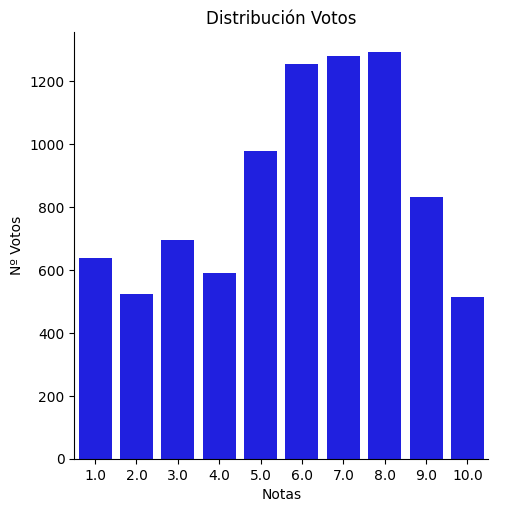

In [6]:
# Veamos la distribución del dataset

import matplotlib.pyplot as plt
import seaborn as sns


sns.catplot(x='review_rate', kind='count', color='b', data=df)
plt.title('Distribución Votos')
plt.xlabel('Notas')
plt.ylabel('Nº Votos')

In [7]:
# Ok, dada la distribución asignaremos etiquetas con criterios según su puntaje recibido.

df['polaridad'] = df['review_rate'].apply(lambda x: 'positivo' if x > 6 else 'negativo')
df.sample(10)

,film_name,gender,film_avg_rate,review_rate,review_title,review_text,polaridad
5867,Tres metros sobre el cielo,Romance,"4,7",1.0,3MSC (3 Maneras de Secar el Cerebro),1º Ver una película con una asquerosa moralina...,negativo
5045,Mientras dure la guerra,Drama,"6,8",8.0,"Guión preciso, magníficas interpretaciones",Muy buena ambientación de época y los actores ...,positivo
6722,El laberinto del fauno,Fantástico,"7,2",8.0,Afortunada mezcla de fantasía y realidad,Una película que mezcla en su historia la fant...,positivo
6499,El laberinto del fauno,Fantástico,"7,2",3.0,Aburrida y desagradable,"La película tiene dos partes, una real y otra ...",negativo
3000,Las aventuras de Tadeo Jones,Animación,"5,3",5.0,"Triunfo en lo gráfico, fracaso en lo artístico",En 2006 Enrique Gato dirigió un corto que le l...,negativo
7353,REC,Terror,"6,6",8.0,Por fin una película de terror que merece ser ...,Nunca me cansaré de visualizar esta gran joya ...,positivo
2003,Ágora,Aventuras,"6,5",9.0,Admirable historia de amor en un clima de terr...,"La producción la dirige José Luis Escolar, qui...",positivo
2490,Mar adentro,Drama,"7,2",6.0,Aprender a llorar riendo,No haber visto a día de hoy esta película hace...,negativo
7926,Las 13 rosas,Drama,"6,6",7.0,Genial ambientación y buenas interpretaciones,Película bastante interesante sobre algunos de...,positivo
5438,Volver,Drama,"7,1",9.0,España cañí,"Magnífica película de Pedro Almodóvar, en la q...",positivo



Cantidad exacta de reviews:
polaridad
negativo    4683
positivo    3920
Name: count, dtype: int64


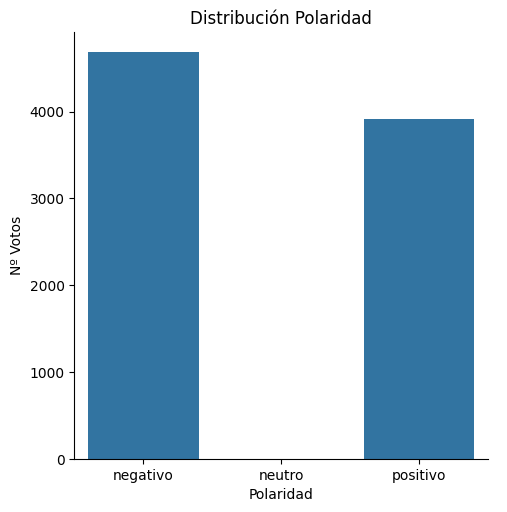

In [8]:
# Vemos la nueva distribución

sns.catplot(x='polaridad', kind='count', data=df,  order=['negativo', 'neutro', 'positivo'])
plt.title('Distribución Polaridad')
plt.xlabel('Polaridad')
plt.ylabel('Nº Votos')

print("\nCantidad exacta de reviews:")
print(df['polaridad'].value_counts())

In [9]:
# Unimeros el titulo de la review y el texto ya que peude aportarnos información.

df['texto'] = df['review_title'] + ' ' + df['review_text']
df.head(5)

# Ahora obtendremos dos collumnas nuevas, 'polaridad' y 'texto' que serán nuestra (y,x)

,film_name,gender,film_avg_rate,review_rate,review_title,review_text,polaridad,texto
0,Ocho apellidos vascos,Comedia,"6,0",3.0,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existen...,negativo,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO...
1,Ocho apellidos vascos,Comedia,"6,0",2.0,El perro verde,"No soy un experto cinéfilo, pero pocas veces m...",negativo,"El perro verde No soy un experto cinéfilo, per..."
2,Ocho apellidos vascos,Comedia,"6,0",2.0,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...,negativo,Si no eres de comer mierda... no te comas esta...
3,Ocho apellidos vascos,Comedia,"6,0",2.0,Aida: The movie,"No sé qué está pasando, si la gente se deja ll...",negativo,"Aida: The movie No sé qué está pasando, si la ..."
4,Ocho apellidos vascos,Comedia,"6,0",2.0,UN HOMBRE SOLO (Julio Iglesias 1987),"""Pero cuando amanece,y me quedo solo,siento en...",negativo,"UN HOMBRE SOLO (Julio Iglesias 1987) ""Pero cua..."


In [10]:
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Valores faltantes por columna:
film_name        0
gender           0
film_avg_rate    0
review_rate      2
review_title     0
review_text      0
polaridad        0
texto            0
dtype: int64


In [11]:
X = df['texto'].values
y =  df['polaridad'].values

In [13]:
# Bien, comencemos con la normalización.
# Usaremos spaCY y en un mismo codigo, haremos lematización, eliminaremos StopWords y signos gramaticales.
import re
import spacy
!python -m spacy download es_core_news_sm
from tqdm import tqdm

# Cargar modelo en español de spaCy
nlp = spacy.load('es_core_news_sm')  # Usa el modelo "sm" o "lg" si es compatible

def normalize(corpus):
    """
    Función para normalizar una lista de textos.
    Pasos realizados:
       1. Convertir texto a minúsculas.
       2. Eliminar signos de puntuación.
       3. Filtrar palabras con longitud entre 3 y 11 caracteres.
       4. Eliminar stopwords.
       5. Eliminar saltos de línea y espacios redundantes.
       6. Filtrar solo Nombres (NOUN), Adjetivos (ADJ), Verbos (VERB) o Adverbios (ADV).
       7. Lemmatizar palabras.
    """
    for index, doc in enumerate(tqdm(corpus, desc="Normalizando texto")):
        doc = nlp(doc.lower())  # Convertir a minúsculas y procesar con spaCy
        corpus[index] = " ".join([
            token.lemma_ for token in doc
            if not token.is_punct  # Eliminar puntuación
            and 3 <= len(token.text) <= 11  # Filtrar longitud de palabras
            and not token.is_stop  # Eliminar stopwords
            and re.sub(r'\s+', ' ', token.text)  # Eliminar espacios redundantes
            and token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']  # Filtrar categorías gramaticales
        ])
    return corpus

# Aplicar normalización
X_norm = normalize(X)  # 'X' es la lista o serie de textos a normalizar

# Ejemplo de resultado
print(X_norm[:5])  # Mostrar las primeras 5 líneas normalizadas





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 69.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Normalizando texto: 100%|██████████| 8603/8603 [06:15<00:00, 22.92it/s]

['apellido vasco nombre virtud película jugar tópico extremo identidad patrio andaluz vasco escandalizar poner grito cielo indicar madurez nación pese pese corrijo jugar mofa tópico vasco vasco escandalizar poner grito cielo indicar grado cuestión llaga abierto dispuesto sangrar corrección andaluz motivo guasa apellido vasco valiente oportuno oportunista seguramente principal razón español acudir masa masa precedente cine producto patrocinado tele acertado fecha estreno verano brutal ejemplar campaña marketing aplaudo celebro.eso celebrar decir repito oscuro placer película mala insistir olvidar principal propósito cine entretener decir mantengo problema apelido vasco malo friki disparatado peli mala"(como sharknado xanadu condemor entretenido perdonar él mediocridad punto palabra define mediocridad mediocre simple sencillo impersonal hecho interesar novedoso sacar elemento entorno totalmente ajeno hostil argumento básico comedia cine cine explicar elemento encajar absoluto película ca

In [14]:
df_normalized = pd.DataFrame({
    'texto_normalizado': X_norm,
    'polaridad': y
})

# Mostrar las primeras filas del nuevo DataFrame
print(df_normalized.head())

                                   texto_normalizado polaridad
0  apellido vasco nombre virtud película jugar tó...  negativo
1  perro verde experto cinéfilo sentir juego sala...  negativo
2  comer mierda comar mierda humor estilo termina...  negativo
3  aido pasar gente dejar moda gustar poner rovir...  negativo
4  hombre julio iglesia amanecer quedar sentir fo...  negativo


In [15]:
from collections import Counter

# Unir todos los textos normalizados en una sola cadena
texto_completo = ' '.join(df_normalized['texto_normalizado'])

# Dividir en palabras individuales
palabras = texto_completo.split()

# Contar la frecuencia de cada palabra
contador_palabras = Counter(palabras)

# Convertir el contador a un DataFrame para mayor claridad
df_frecuencia = pd.DataFrame(contador_palabras.items(), columns=['Palabra', 'Frecuencia'])

# Ordenar el DataFrame por frecuencia descendente
df_frecuencia = df_frecuencia.sort_values(by='Frecuencia', ascending=False).reset_index(drop=True)

# Mostrar las primeras filas
print(df_frecuencia.head(20))


      Palabra  Frecuencia
0    película       19520
1          él        7723
2        cine        6609
3     español        5561
4    historia        5360
5   personaje        4928
6         ver        4741
7       actor        3263
8     momento        3001
9       pasar        2648
10     escena        2592
11      guión        2533
12      dejar        2501
13   director        2363
14       cosa        2262
15     gustar        2253
16     quedar        2007
17        año        2004
18       film        1885
19       malo        1874


In [18]:
# Contamos las palabras en nuestro texto ya procesado
from collections import Counter
palabras = ' '.join(df_normalized['texto_normalizado']).split()
contador_palabras = Counter(palabras)

# Convertimos el conteo a un DataFrame para facilitar el análisis
contador_palabras_df = pd.DataFrame(contador_palabras.items(), columns=['Palabra', 'Frecuencia'])
contador_palabras_df = contador_palabras_df.sort_values(by='Frecuencia', ascending=False)

# Mostramos las 20 palabras más comunes
print(contador_palabras_df.head(40))



         Palabra  Frecuencia
4       película       19520
77            él        7723
40          cine        6609
36       español        5561
115     historia        5360
171    personaje        4928
304          ver        4741
223        actor        3263
402      momento        3001
106        pasar        2648
444       escena        2592
125        guión        2533
294        dejar        2501
127     director        2363
142         cosa        2262
216       gustar        2253
302       quedar        2007
132          año        2004
684         film        1885
67          malo        1874
749       llegar        1823
97       comedia        1800
156        salir        1755
169         vida        1742
1609       papel        1687
211      crítica        1656
514       tiempo        1645
279      parecer        1642
55         decir        1600
375        hacer        1598
7243    amenábar        1484
192      esperar        1480
339        mundo        1454
187     result

In [19]:
import pandas as pd
from collections import Counter
from nltk.util import ngrams
from nltk import word_tokenize

# Función para generar bigramas
def generar_bigramas(textos):
    bigramas_lista = []
    for texto in textos:
        # Generar tokens (ya están normalizados y lematizados en tu columna)
        tokens = texto.split()

        # Crear bigramas a partir de los tokens
        bigramas = list(ngrams(tokens, 3))  # n=2 para bigramas

        # Agregar los bigramas a la lista
        bigramas_lista.extend(bigramas)

    return bigramas_lista

# Aplicamos la función a la columna de texto normalizado
bigramas = generar_bigramas(df_normalized['texto_normalizado'])

# Contar frecuencia de bigramas
contador_bigramas = Counter(bigramas)

# Convertir los bigramas a DataFrame
df_bigramas = pd.DataFrame(contador_bigramas.items(), columns=['Bigrama', 'Frecuencia'])

# Ordenar por frecuencia descendente
df_bigramas = df_bigramas.sort_values(by='Frecuencia', ascending=False).reset_index(drop=True)

# Mostrar los primeros 10 bigramas
print(df_bigramas.head(20))

                            Bigrama  Frecuencia
0             (basado, hecho, real)          90
1         (cine, español, película)          89
2         (historia, cine, español)          83
3            (aventura, tadeo, jón)          76
4          (proyecto, bruja, blair)          70
5        (mejor, película, español)          66
6                   (ver, él, cine)          65
7         (película, cine, español)          62
8          (película, español, año)          60
9              (cine, español, año)          56
10        (película, guerra, civil)          54
11              (tesis, abrir, ojo)          44
12                (volver, ver, él)          43
13              (película, ver, él)          42
14              (ver, él, película)          41
15  (película, español, taquillero)          41
16                  (pena, ver, él)          41
17         (isla, mínimo, película)          39
18            (cine, español, cine)          36
19             (dejar, sabor, boca)     

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# Generar Bag of Words con bigramas
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=2000)  # Unigramas y bigramas, 2000 más frecuentes

# Transformar los textos normalizados a una representación numérica
X_bow = vectorizer.fit_transform(df_normalized['texto_normalizado'])

# Mostrar las características más frecuentes
print("Características más frecuentes (unigramas y bigramas):")
print(vectorizer.get_feature_names_out()[:20])


Características más frecuentes (unigramas y bigramas):
['2004' '2014' 'abajo' 'abandonar' 'abierto' 'abordar' 'abrir' 'abrir ojo'
 'absoluto' 'absurdo' 'abuela' 'aburrido' 'aburrir' 'abusar' 'abuso'
 'acabar' 'acabar película' 'acaso' 'acción' 'acento']


In [21]:
from sklearn.model_selection import train_test_split

# Separar datos (X_bow) y etiquetas (y)
X_train, X_test, y_train, y_test = train_test_split(X_bow, df['polaridad'], test_size=0.2, random_state=42)


[]

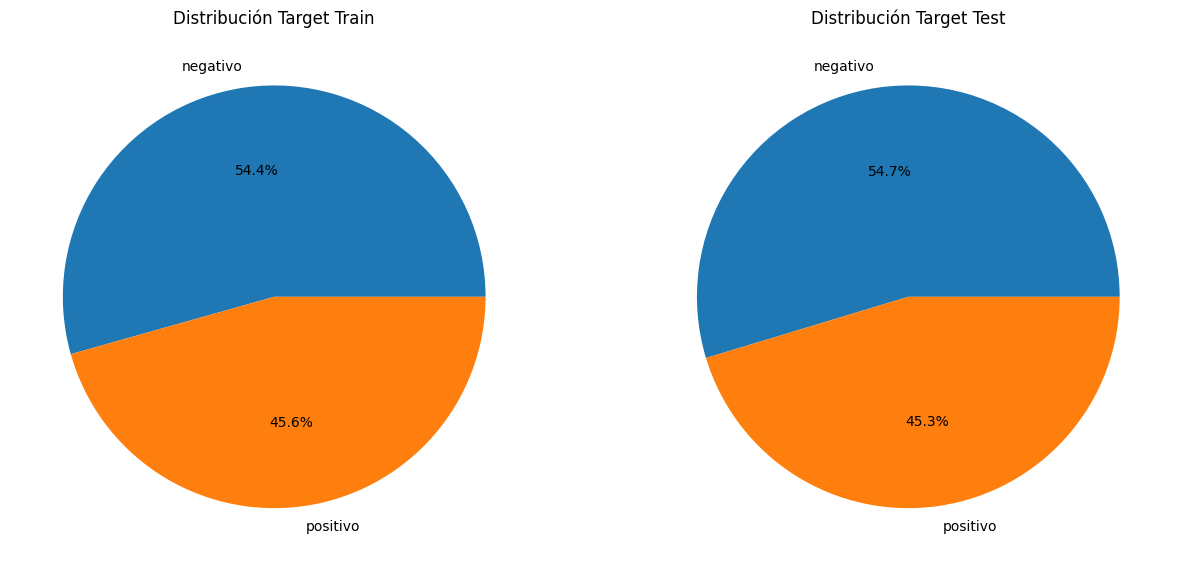

In [22]:
import numpy as np

keys_train, counts_train = np.unique(y_train, return_counts=True)
keys_test, counts_test = np.unique(y_test, return_counts=True)
perct_train = counts_train / np.sum(counts_train)
perct_test = counts_test / np.sum(counts_test)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.pie(perct_train, labels=keys_train, autopct='%1.1f%%')
plt.title('Distribución Target Train')
plt.subplot(1, 2, 2)
plt.pie(perct_test, labels=keys_test, autopct='%1.1f%%')
plt.title('Distribución Target Test')
plt.plot()

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Modelos
modelos = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Diccionario para guardar resultados
resultados = []
matrices_confusion = {}

# Entrenamiento y evaluación
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Evaluación
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Guardar resultados en lista
    resultados.append([nombre, acc, precision, recall, f1])

    # Guardar matriz de confusión
    matrices_confusion[nombre] = confusion_matrix(y_test, y_pred)

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados, columns=["Modelo", "Accuracy", "Precision", "Recall", "F1"])

# Mostrar tabla de resultados con formato
print(df_resultados)


                Modelo  Accuracy  Precision    Recall        F1
0        MultinomialNB  0.761185   0.761657  0.761185  0.761363
1          BernoulliNB  0.745497   0.744909  0.745497  0.744711
2  Regresión Logística  0.749564   0.749907  0.749564  0.749705
3                  SVM  0.779779   0.779394  0.779779  0.779331
4        Random Forest  0.768158   0.767764  0.768158  0.767823


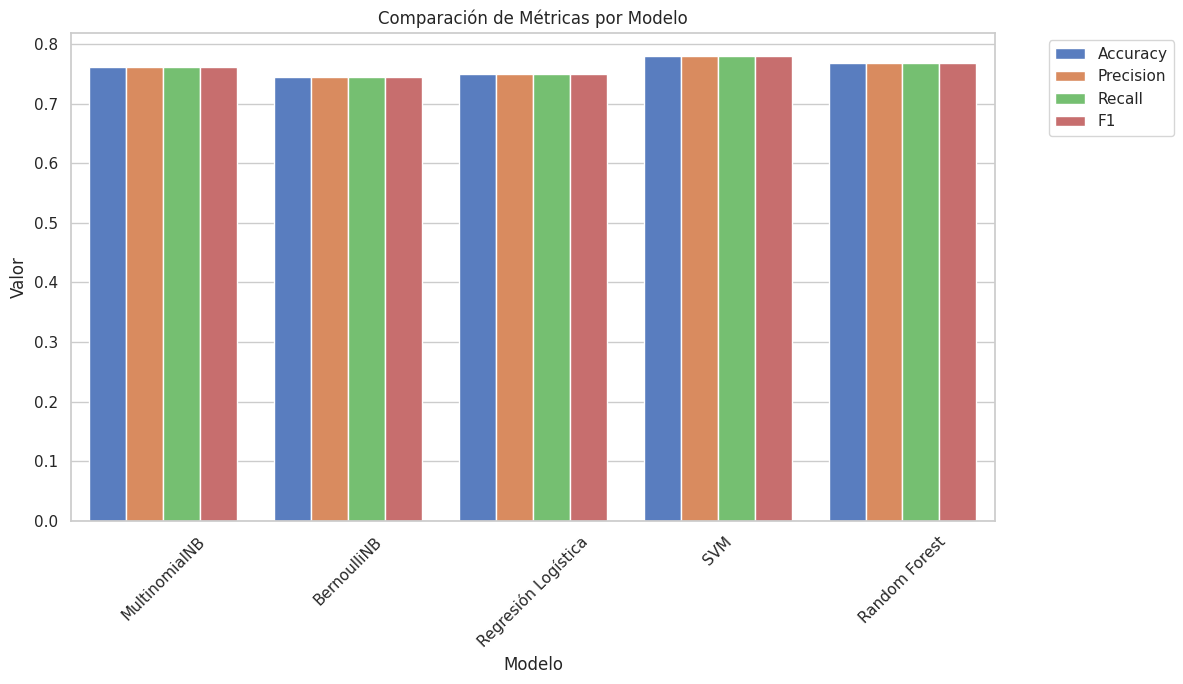

In [24]:
# Configuración de estilo de seaborn
sns.set(style="whitegrid")

# Gráfico de barras con métricas de rendimiento
plt.figure(figsize=(12, 7))
df_resultados_melted = df_resultados.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

sns.barplot(data=df_resultados_melted, x="Modelo", y="Valor", hue="Métrica", palette="muted")
plt.title("Comparación de Métricas por Modelo")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


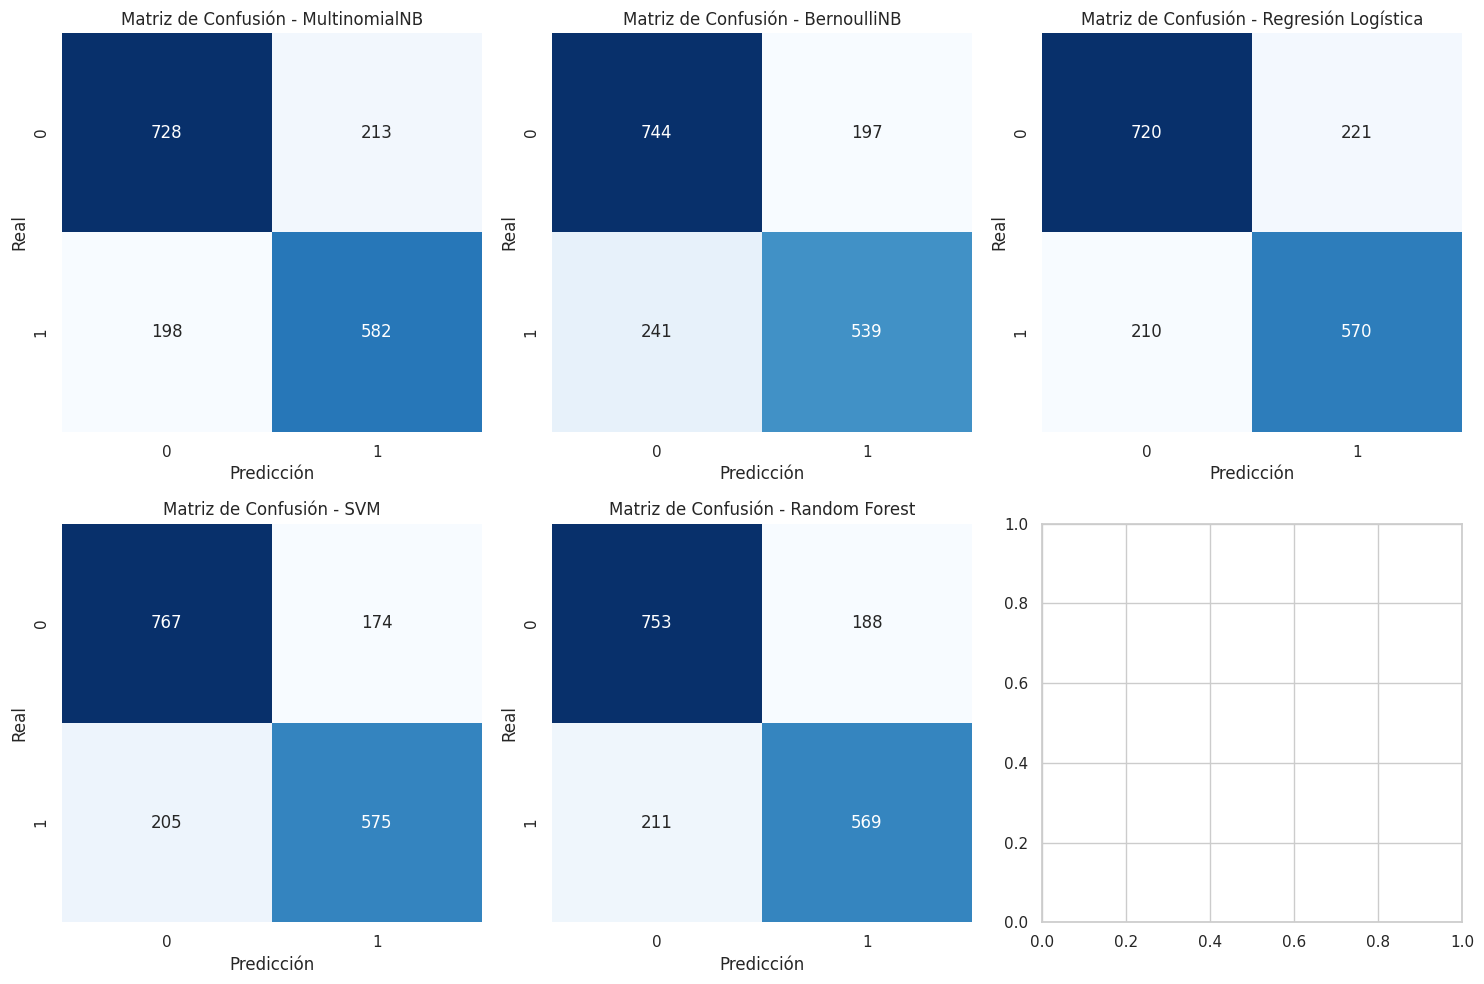

In [25]:
# Graficar las matrices de confusión
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 filas, 3 columnas
axes = axes.flatten()

for i, (nombre, matriz) in enumerate(matrices_confusion.items()):
    sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Matriz de Confusión - {nombre}")
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")

# Ajustar diseño de las subplots
plt.tight_layout()
plt.show()


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Crear TF-IDF con bigramas
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=2000)  # Unigramas y Bigramas, 2000 características

# Aplicar TF-IDF al texto
# Cambiar 'x_norm' por 'texto_normalizado' y el DataFrame 'df' por 'df_normalized'
X_tfidf = tfidf_vectorizer.fit_transform(df_normalized['texto_normalizado'])

# Ajustar las etiquetas: cambiar 'y' por 'polaridad'
y = df_normalized['polaridad']

# Dividir datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)



In [27]:
# Modelos
modelos = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Diccionario para guardar resultados
resultados_tfidf = []
matrices_confusion_tfidf = {}

# Entrenamiento y evaluación
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Evaluación
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Guardar resultados
    resultados_tfidf.append([nombre, acc, precision, recall, f1])

    # Guardar matriz de confusión
    matrices_confusion_tfidf[nombre] = confusion_matrix(y_test, y_pred)

# Crear DataFrame de resultados
df_resultados_tfidf = pd.DataFrame(resultados_tfidf, columns=["Modelo", "Accuracy", "Precision", "Recall", "F1"])

# Mostrar tabla de resultados
print(df_resultados_tfidf)


                Modelo  Accuracy  Precision    Recall        F1
0        MultinomialNB  0.767919   0.767338  0.767919  0.766859
1          BernoulliNB  0.753196   0.752432  0.753196  0.752236
2  Regresión Logística  0.784192   0.783808  0.784192  0.783913
3                  SVM  0.785742   0.785425  0.785742  0.785531
4        Random Forest  0.760558   0.759926  0.760558  0.759998


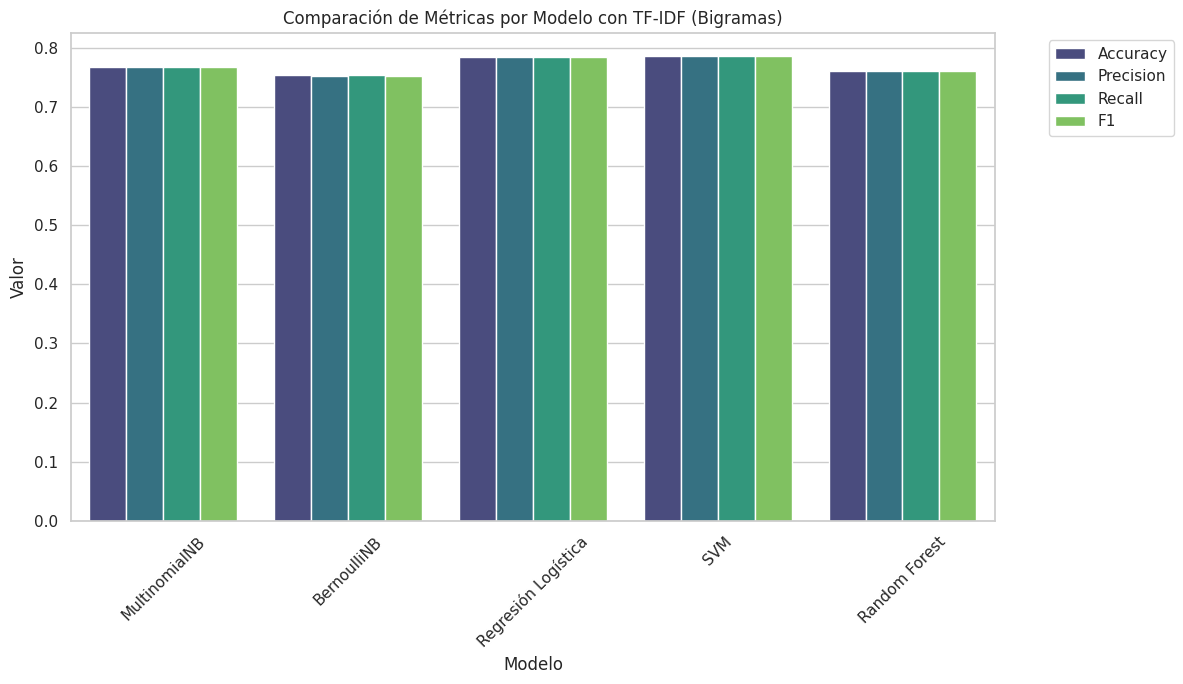

In [28]:
# Vemos que apenas ha mejorado el resultado

# Gráfico de barras con métricas de rendimiento usando TF-IDF
plt.figure(figsize=(12, 7))
df_resultados_tfidf_melted = df_resultados_tfidf.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

sns.barplot(data=df_resultados_tfidf_melted, x="Modelo", y="Valor", hue="Métrica", palette="viridis")
plt.title("Comparación de Métricas por Modelo con TF-IDF (Bigramas)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


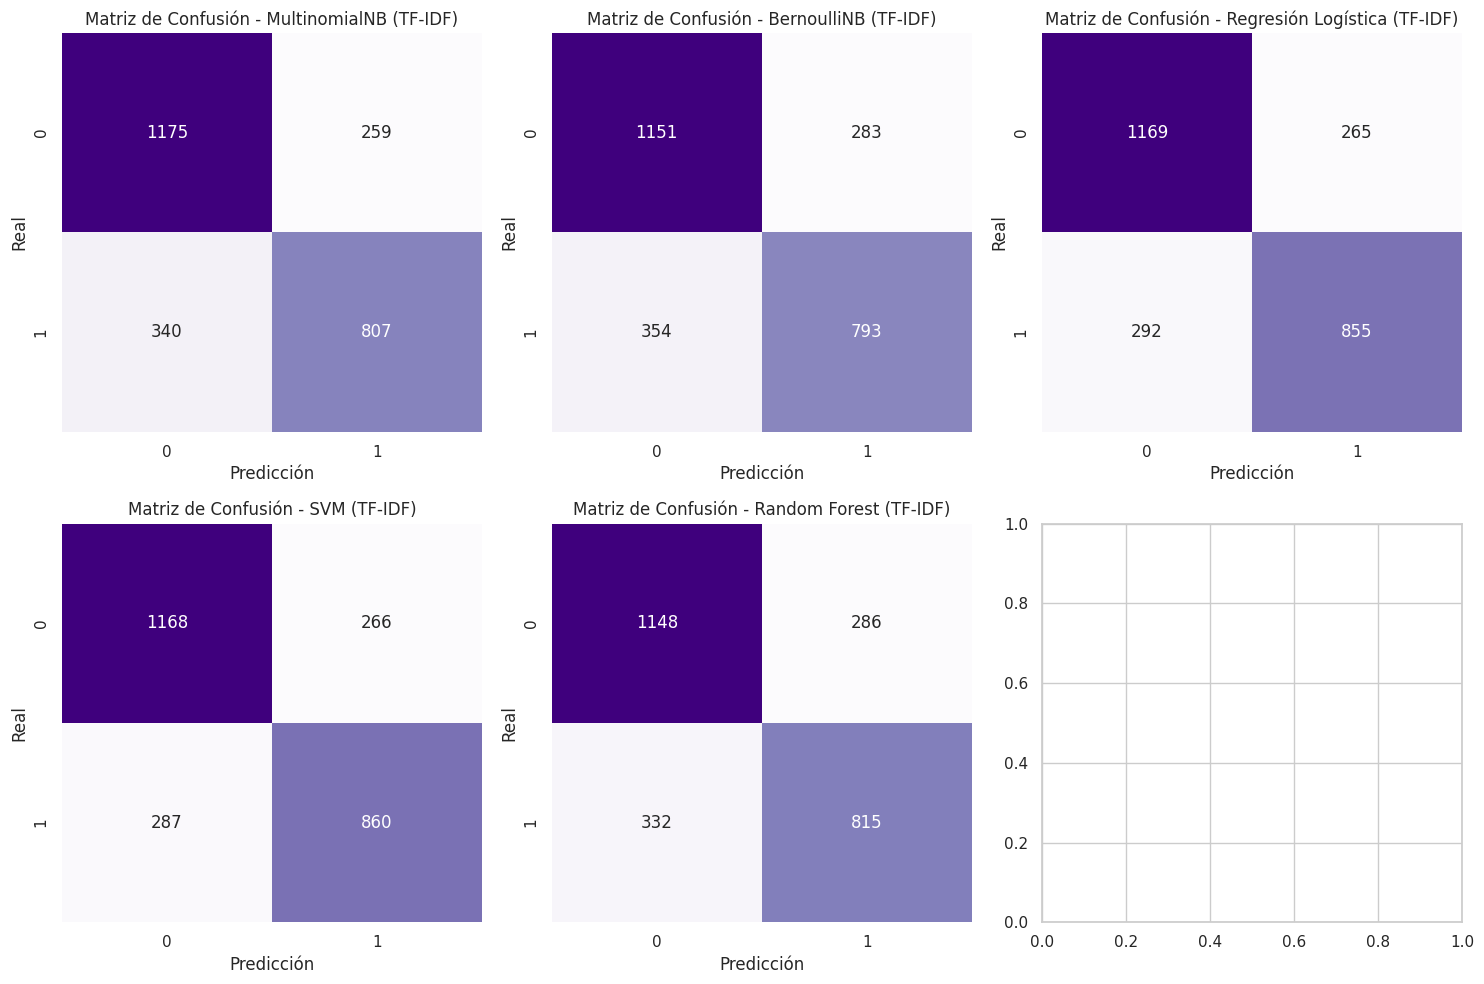

In [29]:
# Graficar las matrices de confusión
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (nombre, matriz) in enumerate(matrices_confusion_tfidf.items()):
    sns.heatmap(matriz, annot=True, fmt="d", cmap="Purples", ax=axes[i], cbar=False)
    axes[i].set_title(f"Matriz de Confusión - {nombre} (TF-IDF)")
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")

plt.tight_layout()
plt.show()


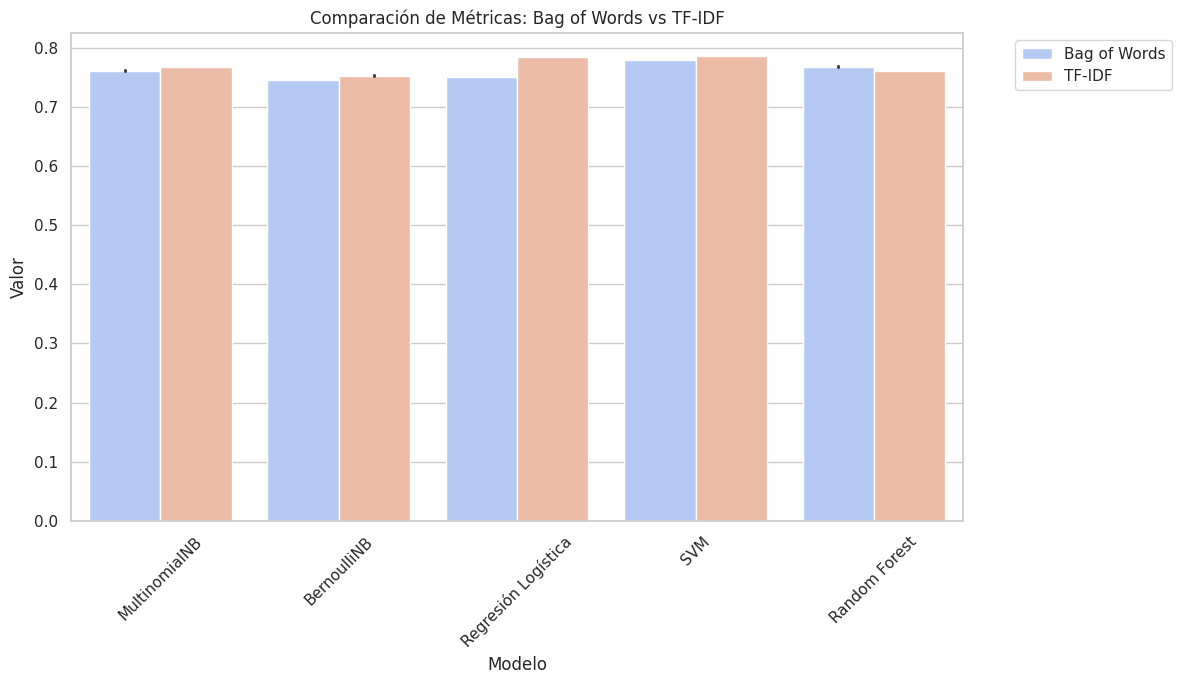

In [30]:
# Comparar resultados de BoW vs TF-IDF
df_resultados["Vectorización"] = "Bag of Words"
df_resultados_tfidf["Vectorización"] = "TF-IDF"

df_comparativa = pd.concat([df_resultados, df_resultados_tfidf])

# Graficar comparativa
plt.figure(figsize=(12, 7))
df_comparativa_melted = df_comparativa.melt(id_vars=["Modelo", "Vectorización"], var_name="Métrica", value_name="Valor")

sns.barplot(data=df_comparativa_melted, x="Modelo", y="Valor", hue="Vectorización", palette="coolwarm")
plt.title("Comparación de Métricas: Bag of Words vs TF-IDF")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [32]:
# Reseñas de ejemplo inventadas (positivas y negativas)
nuevas_reseñas = [
    "Me encantó la película, la trama fue excelente y los actores estuvieron increíbles. ¡Recomendada totalmente!",  # Positiva
    "Es una película aburrida, los efectos especiales son malos y la historia no tiene sentido. No la recomiendo.",  # Negativa
    "Una de las mejores películas que he visto en años, llena de emoción y con un mensaje muy profundo. ¡Impresionante!",  # Positiva
    "Pésima película, me aburrí desde el principio. No entiendo cómo alguien pudo disfrutarla.",  # Negativa
    "La película fue buena, pero me esperaba más. Los giros de la trama fueron previsibles.",  # Negativa
    "La peor película que he visto en mi vida, pésima actuación y mal guion. No la recomiendo para nada."  # Negativa
]

# Usar el mismo vectorizador (tfidf_vectorizer) para transformar las nuevas reseñas
X_nuevas = tfidf_vectorizer.transform(nuevas_reseñas)

# Instanciar y entrenar el modelo SVM (si no lo has hecho antes)
svm_model = SVC()
svm_model.fit(X_train, y_train)  # Entrenar con tus datos de entrenamiento

# Predecir con el modelo SVM
predicciones = svm_model.predict(X_nuevas)

# Mostrar las predicciones
for reseña, prediccion in zip(nuevas_reseñas, predicciones):
    sentimiento = 'Positiva' if prediccion == 'positivo' else 'Negativa' # Assuming 'positivo' and 'negativo' are your labels
    print(f"Reseña: {reseña}\nSentimiento Predicho: {sentimiento}\n")

Reseña: Me encantó la película, la trama fue excelente y los actores estuvieron increíbles. ¡Recomendada totalmente!
Sentimiento Predicho: Positiva

Reseña: Es una película aburrida, los efectos especiales son malos y la historia no tiene sentido. No la recomiendo.
Sentimiento Predicho: Negativa

Reseña: Una de las mejores películas que he visto en años, llena de emoción y con un mensaje muy profundo. ¡Impresionante!
Sentimiento Predicho: Positiva

Reseña: Pésima película, me aburrí desde el principio. No entiendo cómo alguien pudo disfrutarla.
Sentimiento Predicho: Negativa

Reseña: La película fue buena, pero me esperaba más. Los giros de la trama fueron previsibles.
Sentimiento Predicho: Negativa

Reseña: La peor película que he visto en mi vida, pésima actuación y mal guion. No la recomiendo para nada.
Sentimiento Predicho: Negativa

